# Influencers in Social Networks
### Al Byun, VIncent Chio, Hussein Danish, NIck Hamlin, Walter Erquinigo Pazo
### W207 Final Project, Fall 2015

# Table of Contents
* [Problem Statement](#Problem-Summary)
* [Summary of Results](#Summary-of-Results)
* [Data Preparation](#Data-Preparation)
* [Initial Data Exploration](#Initial-Data-Exploration)
* [Feature Transformation](#Feature-Transformation)
* [Further Data Exploration](#Further-Data-Exploration)
* [Non-Linear Feature Transformation](#Non-Linear-Transformation-Using-KernelPCA)
* [Initial Model Evaluation](#Initial-Model-Evaluation)
* [Feature Engineering](#Feature-Engineering)
* [Error Analysis and Advanced Modeling](#Error-Analysis-and-Advanced-Modeling)
* [Kaggle Submission](#Kaggle-Submission)
* [Appendix](#Appendix)

# Problem Statement

For this project, we've entered the ["Influencers in Social Networks: Predict which people are influential in a social network"](https://www.kaggle.com/c/predict-who-is-more-influential-in-a-social-network/data) competition on Kaggle.

As per the [problem description page:](https://www.kaggle.com/c/predict-who-is-more-influential-in-a-social-network)

*The dataset, provided by Peerindex, comprises a standard, pair-wise preference learning task. Each datapoint describes two individuals, A and B. For each person, 11 pre-computed, non-negative numeric features based on twitter activity (such as volume of interactions, number of followers, etc) are provided.*

*The binary label represents a human judgement about which one of the two individuals is more influential. A label '1' means A is more influential than B. 0 means B is more influential than A.*

*The goal of the challenge is to train a machine learning model which, for pairs of individuals, predicts the human judgement on who is more influential with high accuracy.*

In addition, Kaggle provides the following benchmarks against which we can compare our results

| Benchmark                                                | AUC     |
|----------------------------------------------------------|---------|
| Random Guessing                                          | 0.50438 |
| Always choose user with more followers                   | 0.75175 |
| Baseline Sklearn Solution (Simple Logistic Regression)   | 0.85587 |
| Best Solution on Kaggle                                  | 0.88162 |

#Summary of Results
The values shown below represent the results associated with the different submissions we made to Kaggle. These values differ from the AUCs we calculated to compare our results internally since we use a homemade dev dataset based on a subset of the provided training data rather than submitting to Kaggle each time we made a tweak to a model.

| Method                                                    | Kaggle Calculated AUC     |
|-----------------------------------------------------------|---------|
| Initial “dumb” solution (K-Nearest Neighbors)             | 0.61    |
| Logistic regression with optimized hyperparameters        | 0.86048 |
| Optimized logistic regression with bagging                | 0.86103 |
| Bagged logistic regression with graph centrality features | 0.86111 |
| Logistic regression with Bagged gradient boosting         | 0.86161 |
| Logistic regression\*0.7 + Random Forest\*0.3             | 0.86359 |

# Data Preparation<a id='data_preparation'></a>
Import all necessary modules, load train and test data, and use a subset of the training data as a dev data set.

In [1]:
# Import all the necessary libraries
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import hashlib

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import networkx as nx

# Neural Network
# pip install https://storage.googleapis.com/tensorflow/mac/tensorflow-0.5.0-py2-none-any.whl
import tensorflow as tf

In [2]:
# Load the train and test data
def load_train_data():
    with open('data/train.csv') as f:
        features = f.next().rstrip().split(',')[1:]
        data = np.loadtxt(f, delimiter=',')
        X, Y = data[:,1:], data[:,:1]
        return features, X, Y.flatten()

def load_test_data():
    with open('data/test.csv') as f:
        features = f.next().rstrip().split(',')[1:]
        return np.loadtxt(f, delimiter=',')

def prepare_train_data(X, Y, test_size=1.0/6):
    np.random.seed(0)
    
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, Y = X[shuffle], Y[shuffle]
    break_point = int(X.shape[0] * (1 - test_size))
    return X[:break_point], Y[:break_point], X[break_point:], Y[break_point:]

#We'll create a dev dataset out of the training data provided so we can 
#optimize our models without having to submit to Kaggle for every iteration.

features, X, Y = load_train_data()
train_data, train_labels, dev_data, dev_labels = prepare_train_data(X, Y)
test_data = load_test_data()

print train_data.shape, dev_data.shape, test_data.shape

(4583, 22) (917, 22) (5952, 22)


# Initial Data Exploration
Before we do any model-building, we need to understand the features we're given to work with. Pandas makes initial examination and calculation of summary stats easy  

In [10]:
train_dataframe=pd.DataFrame(train_data)
train_dataframe.describe()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
count,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000,...,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000
mean,643289.227798,12278.108444,6006.005237,2829.676174,1081.691769,6.027848,1.110023,8.989718,5388.697142,85.668595,...,12770.484399,5860.172813,2404.659522,949.782862,6.084044,1.104897,9.409922,5196.338861,84.932956,3746.269205
std,2041521.761510,45486.703634,18248.431242,31562.494713,11867.827432,9.509382,1.904360,18.010443,30526.026173,105.643234,...,50093.744151,14876.703726,20989.024436,7762.079625,9.644431,1.942510,19.206669,24738.732215,105.163555,5521.280666
min,16.000000,0.000000,0.000000,0.100503,0.100503,0.100503,0.100503,0.100503,0.000000,0.000000,...,0.000000,0.000000,0.100503,0.100503,0.100503,0.100503,0.100503,0.000000,0.000000,0.000000
25%,2651.000000,322.000000,85.000000,3.453649,0.716816,0.359534,0.100503,0.820108,12.000000,15.176568,...,322.000000,75.000000,3.444003,0.715686,0.356943,0.100503,0.822584,12.000000,16.111111,1230.512781
50%,45589.000000,779.000000,942.000000,48.765417,14.029113,2.324112,0.341936,3.583596,195.000000,55.641791,...,773.000000,932.000000,48.765417,14.029113,2.251398,0.341936,3.367388,193.000000,54.925234,2206.420734
75%,392738.000000,2838.000000,6734.000000,374.369869,124.471540,7.198330,1.320681,10.691878,1323.000000,109.695652,...,2838.000000,6734.000000,349.819625,107.081021,6.946233,1.320681,10.600502,1323.000000,112.191489,4345.216686
max,36543194.000000,550744.000000,549144.000000,1145218.987880,435825.874241,76.809514,16.290540,193.072418,920838.000000,1121.000000,...,664324.000000,549144.000000,1145218.987880,435825.874241,76.809514,16.290540,193.072418,920838.000000,1861.583333,75526.083333


In [8]:
#Display a sample of the raw data
train_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,366460,466,3381,1167.896930,415.263914,49.918633,8.061557,82.535177,3450,17.914359,...,67047,5103,150.340456,68.117366,5.480349,0.100503,71.879274,568,205.883275,9580.395470
1,3166413,276,603,1253.345429,980.120926,12.963425,2.380018,100.537797,4801,7.906174,...,473,16,2.215723,0.538122,0.100503,0.100503,0.362150,10,91.900000,2778.900000
2,1404323,563,20057,967.720642,579.431128,4.473798,0.805680,6.241806,4027,57.643839,...,221,165,7.362302,0.100503,4.031142,0.860755,2.563721,21,109.695652,5559.869565
3,362,183,9,2.127477,1.860517,0.362150,0.100503,2.321538,8,32.375000,...,3308,713,21.100497,6.218271,0.885443,0.100503,0.362150,85,78.333333,3680.701149
4,48711,22845,932,61.924804,18.578901,0.100503,0.100503,0.100503,229,80.343348,...,997,29,2.292465,0.312366,5.135358,2.032459,4.423156,11,192.363636,3855.727273


Examining a sample of the raw data is useful for getting a sense of what's available, but it's easier to spot larger trends by plotting histograms of each feature

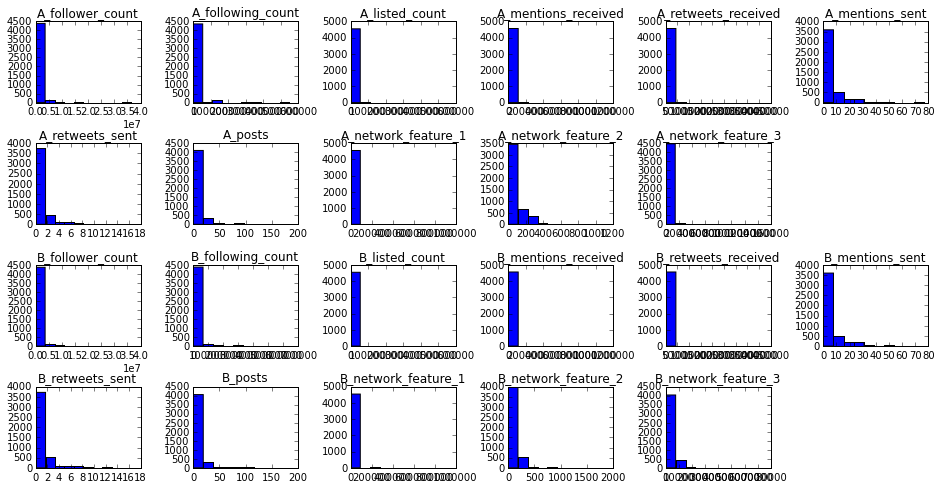

In [3]:
plt.figure(figsize=(16, 8))
for i, feature in enumerate(features):
    plt.subplot(4,6,i+1 if (i < len(features)/2) else i+2)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.hist(train_data[:,i])
    plt.title(feature)

Here, we see that all the pairwise features are heavily positively skewed. Therefore we perform $log(1+feature)$ transformation on all the features. In addition, we calculate the pairwise difference on all the features $log(1+feature_A)-log(1+feature_B)$ and use them as the new features. This enables us to include the same information provided in the initial feature space with half the original number of features.

Next, we define a helper function to test a simple baseline implementation of logistic regression based on the features provided

In [3]:
# This is the baseline test for the improvement of features 
# based on prediction results from a simple model

def accuracy_features(mod_train_data, train_labels, mod_dev_data, dev_labels):
    """
    This function is called accuracy_features since we were originally using it
    to produce accuracy scores.  However, we've changed it to use AUC since this 
    is the metric by which Kaggle is evaluating the models.  Although the output
    is updated, we didn't change the function name, since this would've required
    a significant code update.
    """
    
    lr = LogisticRegression(C=1, penalty='l2')
    lr.fit(mod_train_data, train_labels)
    
    preds = lr.predict(mod_dev_data)

    print "AUC: %(score)s" % {'score': round(roc_auc_score(dev_labels, preds), 5)}
        
# print AUC of original dataset
accuracy_features(train_data, train_labels, dev_data, dev_labels)

AUC: 0.7482


While we're setting up useful tools to automate future problem solving, now is also a good opportunity to define helper functions for hyperparameter optimization that we'll need later on. First, we set up a quick implementation of GridSearchCV to enable quick tuning of hyperparameters for different models.  We then created another function to iterate through the GridSearch results and cleanly report the best answer.

In [4]:
def train_gridsearch_classifier(classifier, param, train_data, train_labels):
    """Use GridSearchCV to find the best estimator using the specified parameters.
    
    f1_weighted is used as the scoring metric.
    
    @param classfier: The base classifier.
    @param param: The parameters to be evaluated.
    @param train_data: The training data.
    @param train_labels: The training labels.
    @return The Grid classifier trained with the best estimator.
    """
    grid_cls = GridSearchCV(classifier, param, scoring='roc_auc')
    grid_cls.fit(train_data, train_labels)
    return grid_cls

def report_score(grid_cls, dev_data, dev_labels, report_best_only=False):
    """Report the result from  GridSearchCV.
    
    Example:
    ---------------------------------------------------------------
    Parameters scores:
    mean: 0.40479, std: 0.01913, params: {'n_neighbors': 1}
    mean: 0.40851, std: 0.02859, params: {'n_neighbors': 5}
    mean: 0.41284, std: 0.02365, params: {'n_neighbors': 10}
    mean: 0.42409, std: 0.01053, params: {'n_neighbors': 50}

    Best param: {'n_neighbors': 50}, f1-score: 0.418
    ---------------------------------------------------------------
    
    @param grid_cls: A trained classifier using GridSearchCV.
    @param dev_data: The development data.
    @param dev_labels: The development labels.
    @param report_best_only: True if only report best parameter score, otherwise false.
    """
    pred_labels = grid_cls.predict(dev_data)
    if not report_best_only:
        print "Parameters scores:"
        for grid_score in grid_cls.grid_scores_:
            print grid_score
        print "\n"
    print "Best param: %(best)s, AUC: %(score)s" % {
        'best': grid_cls.best_params_, 'score': round(roc_auc_score(dev_labels, pred_labels), 3)
    }

# Feature transformation 
Using the results of our initial visualizations and our helper functions, we can apply some basic transformations to the features provided.

In [5]:
# Pairwise transform:
# Divide each row in two parts, one for each person in the comparison and subtract the logs of them.
# A +1 factor is used to have only non-negative logs.
def log_features(x):
    return np.log(1+x)

def pairwise_transform(data):
    return log_features(data[:,0:11]) - log_features(data[:,11:])

def pairwise_features_transform(features):
    return ['d_'+feature[2:] for feature in features[:11]]

train_data_transformed = pairwise_transform(train_data)
dev_data_transformed = pairwise_transform(dev_data)
test_data_transformed = pairwise_transform(test_data)
X_transformed = pairwise_transform(X)
features_transformed = pairwise_features_transform(features)

print train_data_transformed.shape, dev_data_transformed.shape, test_data_transformed.shape

(4583, 11) (917, 11) (5952, 11)


In [8]:
accuracy_features(train_data_transformed, train_labels, dev_data_transformed, dev_labels)

AUC: 0.7481


Replotting the same histograms as above confirms that our transformations have succeeded in normalizing the distributions of our new features.

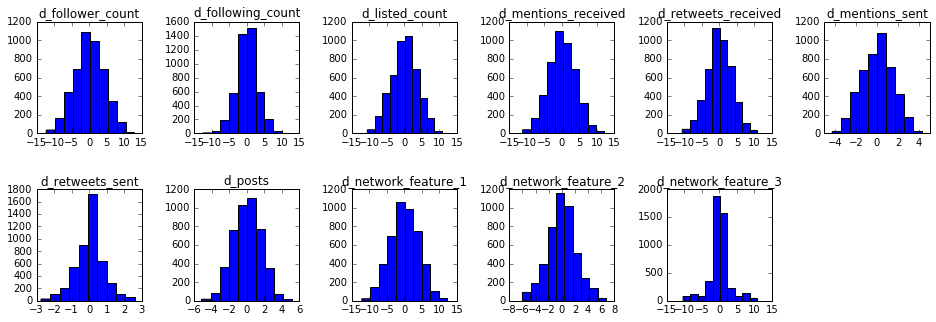

In [11]:
plt.figure(figsize=(16, 5))
for i, feature in enumerate(features_transformed):
    plt.subplot(2,6,i+1)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.hist(train_data_transformed[:,i])
    plt.title(feature)

# Further Data Exploration
Once we normalized the data, we wanted to know if there were any "easy wins".  To explore more deeply, we plotted pairs of features against each other with the outcome variable shown in red or blue.  Here, we're looking to see if any pairs of features are easily linearly separable.

In [6]:
def plot_two_dim_data(data, labels, first_dim=0, second_dim=1):
    """Plot a scatterplot on the specified two dimensions.
    
    @param data: The data set.
    @param labels: The labels.
    @params first_dim: The index of the first dimension of the data set.
    @params second_dim: The index of the second dimension of the data set.
    """
    plt.scatter(data[:, first_dim], data[:, second_dim],
          c=labels, cmap=ListedColormap(['red', 'blue']), alpha=0.5)

def plot_combinatory_two_dim_data(data, labels):
    """Plot the two dimensional combinatory scatterplot.
    
    Each row contains the scatterplots of one dimension to all subsequent dimensions.
    For example:
    First row contains the scatterplots of first dimension against second dimension, third dimension, and so on.
    Second row contains the scatterplots of second dimension against third dimension, fourth dimension, and so on.
    
    @param data: The data set.
    @param labels: The labels.
    """
    plt.figure(figsize=(20, 20))
    features_len = data.shape[1]
    for i in range(0, features_len):
        c = 1
        for j in range(i+1, features_len):
            plt.subplot(features_len, features_len, (i+1)*features_len + c)
            plt.subplots_adjust(wspace=0.5, hspace=0.5)
            plot_two_dim_data(data, labels, i, j)
            c += 1

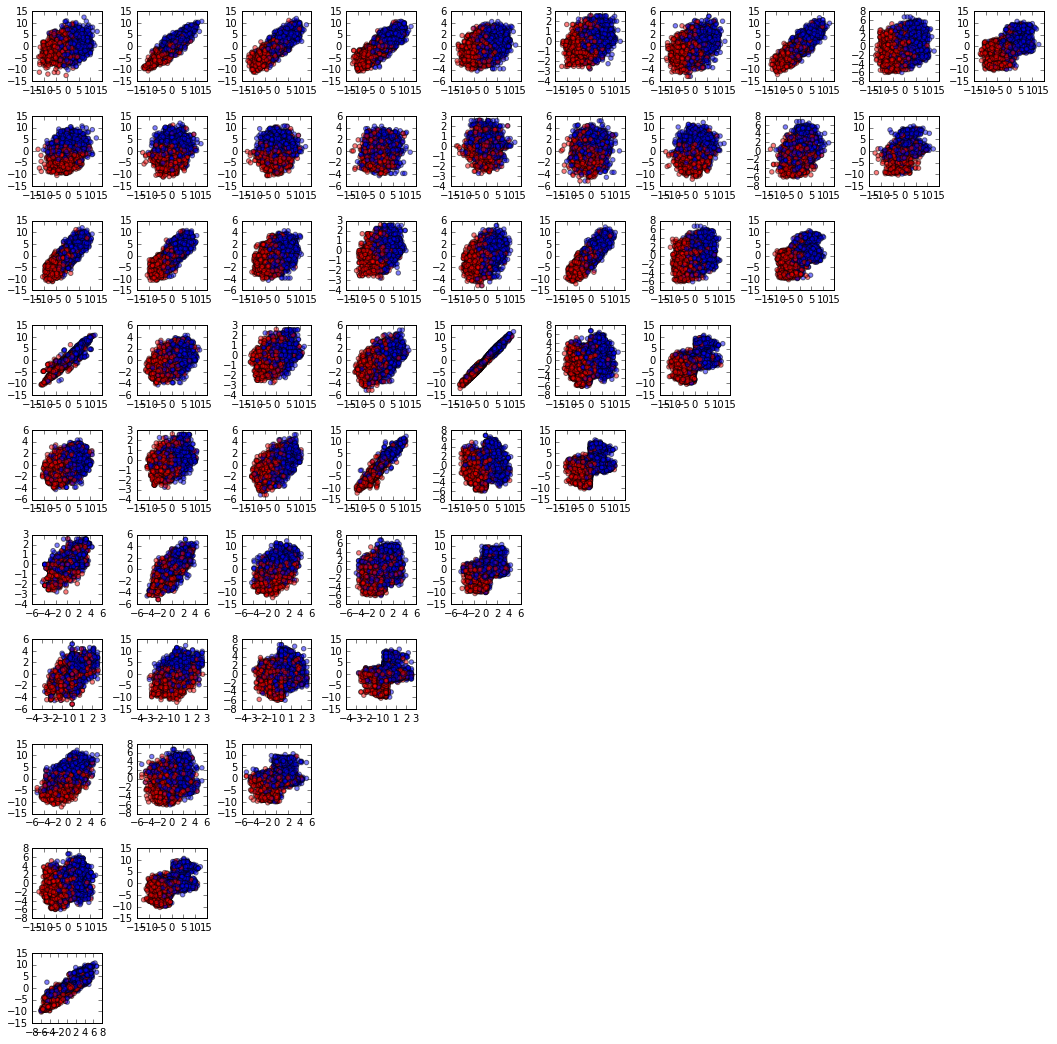

In [13]:
# Plot the two dimensional combinatory relationship across all 11 dimension
plot_combinatory_two_dim_data(train_data_transformed, train_labels)

Sure enough, the combinatory scatterplots of the transformed data set don't show any pair of features that can be separated by a clear linear hyperplane. Therefore, we need to look into non-linear transformation mechanisms instead.

# Non-Linear Transformation Using KernelPCA

Using our GridSearch functions we implemented earlier, we tested whether a non-linear transformation on our feature space using a Kernel PCA approach would give us better linear separation.

In [12]:
print "KernelPCA Calibration:\n"
kernel_lr = Pipeline([('kernel', KernelPCA()), ('lr', LogisticRegression())])
params = {'kernel__kernel': ['linear', 'poly', 'rbf'],
          'kernel__n_components': [9, 10, 11],
          'kernel__gamma': [0.001],
          'lr__C': [0.1]}
lg_grid_cls = train_gridsearch_classifier(kernel_lr,
                                       params,
                                       train_data_transformed, train_labels)
report_score(lg_grid_cls, dev_data_transformed, dev_labels, True)
print "------------------------------------------\n"

KernelPCA Calibration:

Best param: {'kernel__kernel': 'linear', 'kernel__n_components': 11, 'kernel__gamma': 0.001, 'lr__C': 0.1}, AUC: 0.748
------------------------------------------



The calibration process picked the linear transformation over other non-linear transformation kernels. This suggests that the non-linear transformation is not able to provide better linear separation between the classes. [The two dimensional data visualization](#KernelPCA-Visualization) in the Appendix shows that the non-linear transformation actually makes data even harder to separate, so we did not pursue this kind of transform in our final model

# Initial Model Evaluation

We initially tested several of the different classifier classes available in scikit-learn to establish the basis for our modeling. Though most performed poorly "out of the box" with no optimization, we chose to focus on the best two results for our initial evaluation.

In [13]:
print "KNN Calibration:\n"
params = {'n_neighbors': [1, 10, 30, 50, 100, 200, 500],
          'weights': ['uniform', 'distance']}
lg_grid_cls = train_gridsearch_classifier(KNeighborsClassifier(),
                                       params,
                                       train_data_transformed, train_labels)
report_score(lg_grid_cls, dev_data_transformed, dev_labels, True)
print "------------------------------------------\n"

print "Logistic Regression Calibration:\n"
params = {'C': [1, 0.1, 0.01, 0.001, 0.0001],
          'penalty': ['l1', 'l2']}
lg_grid_cls = train_gridsearch_classifier(LogisticRegression(),
                                       params,
                                       train_data_transformed, train_labels)
report_score(lg_grid_cls, dev_data_transformed, dev_labels, True)
print "------------------------------------------\n"

KNN Calibration:

Best param: {'n_neighbors': 100, 'weights': 'uniform'}, AUC: 0.751
------------------------------------------

Logistic Regression Calibration:

Best param: {'penalty': 'l2', 'C': 0.1}, AUC: 0.748
------------------------------------------



Although KNN seems to give higher AUC in terms of predicting the dev data set, it heavily suffers from overfitting when is applied to test data. This is probably due to the nature of the continuous variable and the highly populated cluster around the centroid among the two classes.

In contrast, logistic regression seems to be a better fit to the data, which is likely why it was chosen by the contest administrators as the baseline benchmark solution used on the Kaggle leaderboard. Still, the performance of this simple logistic regression model has significant room for improvement.  This is again likely caused by the dense cluster of data surrounding the centroid between the two classes that is highly non-linear.

# Feature Engineering

## Network Features

Since the data contains comparisons between pairs of users, our first idea for additional features to create was to treat each user as a node in a graph and consider each pairwise comparison between them as an undirected edge.  This methodology allows us to calculate different graph properties for each user, such as centrality, betweeness and closeness, to include as new features in our model. To accomplish this, we use a hashing function to uniquely identify each user across all the different pairwise comparisons.

In [14]:
## Functions for graph feature processing

# Rolling-hash on the features of a person
def hash(a):
    base = 100
    res = 0
    for i in range(len(a)):
        res += base ** i * a[i]
    return res

# Creates an undirected graph where all the rows, which are comparisons, are represented by edges.
def get_edges(x):
    A = x[:,:11]
    B = x[:,11:]

    mapa = {}
    tot = 0
    edges = []
    adj = {}
    for i in range(len(A)):
        a = hash(list(A[i]))
        if a not in mapa:
            mapa[a] = tot
            adj[tot] = set()
            tot += 1
        b = hash(list(B[i]))
        if b not in mapa:
            mapa[b] = tot
            adj[tot] = set()
            tot += 1
        edges.append((mapa[a], mapa[b]))
        adj[mapa[a]].add(mapa[b])
        adj[mapa[b]].add(mapa[a])
    return edges, tot, adj
            
# Pairwise transform for simple numbers
def subtractlogs(a, b):
    return np.log(1 + a) - np.log(1 + b)

# Given two sets of features, create a graph of their combination
def create_graph(x1, x2):
    x = np.concatenate((x1, x2))
    edges, n, adj = get_edges(x)
    ug = nx.Graph()
    map(lambda i: ug.add_node(i), range(n))
    map(lambda (a, b): ug.add_edge(a, b), edges)
    return ug

# Calculate several graph centrality measures
def network_features(ug, x1, x2):
    x = np.concatenate((x1, x2))
    edges, n, adj = get_edges(x)
    
    pr = nx.pagerank(ug)
    degc = nx.degree_centrality(ug)
    close = nx.closeness_centrality(ug)
    load = nx.load_centrality(ug)
    bet = nx.betweenness_centrality(ug)
    ecc = nx.eccentricity(ug)
    
    features = []
    for i in range(len(x)):
        a = edges[i][0]
        b = edges[i][1]
        features.append([
            subtractlogs(degc[a], degc[b]),
            subtractlogs(close[a], close[b]),
            subtractlogs(len(adj[a]), len(adj[b])),
            subtractlogs(load[a], load[b]),
            subtractlogs(bet[a], bet[b]),
            subtractlogs(ecc[a], ecc[b]),
            subtractlogs(pr[a], pr[b])
        ])
    return features[:len(x1)], features[len(x1):]

In [21]:
# Create an undirected graph of the combination of the train and test data
ug = create_graph(train_data_transformed, test_data_transformed)
ug_dev = create_graph(dev_data_transformed, test_data_transformed)

# Combine the original features with the network features
x_feat, test_x_feat = network_features(ug, train_data_transformed, test_data_transformed)
x = np.concatenate((train_data_transformed, x_feat), axis=1)
test_x = np.concatenate((test_data_transformed, test_x_feat), axis=1)

dev_x_feat, dev_test_x_feat = network_features(ug_dev, dev_data_transformed, test_data_transformed)
dev_x = np.concatenate((dev_data_transformed, dev_x_feat), axis=1)

print np.shape(x), np.shape(dev_x), np.shape(test_x)

(4583, 18) (917, 18) (5952, 18)


In [22]:
accuracy_features(x, train_labels, dev_x, dev_labels)

AUC: 0.74919


Finally, having created all the graph centrality metrics, we can use our plotting function from earlier to visualize our results and understand how these new features might affect the model.

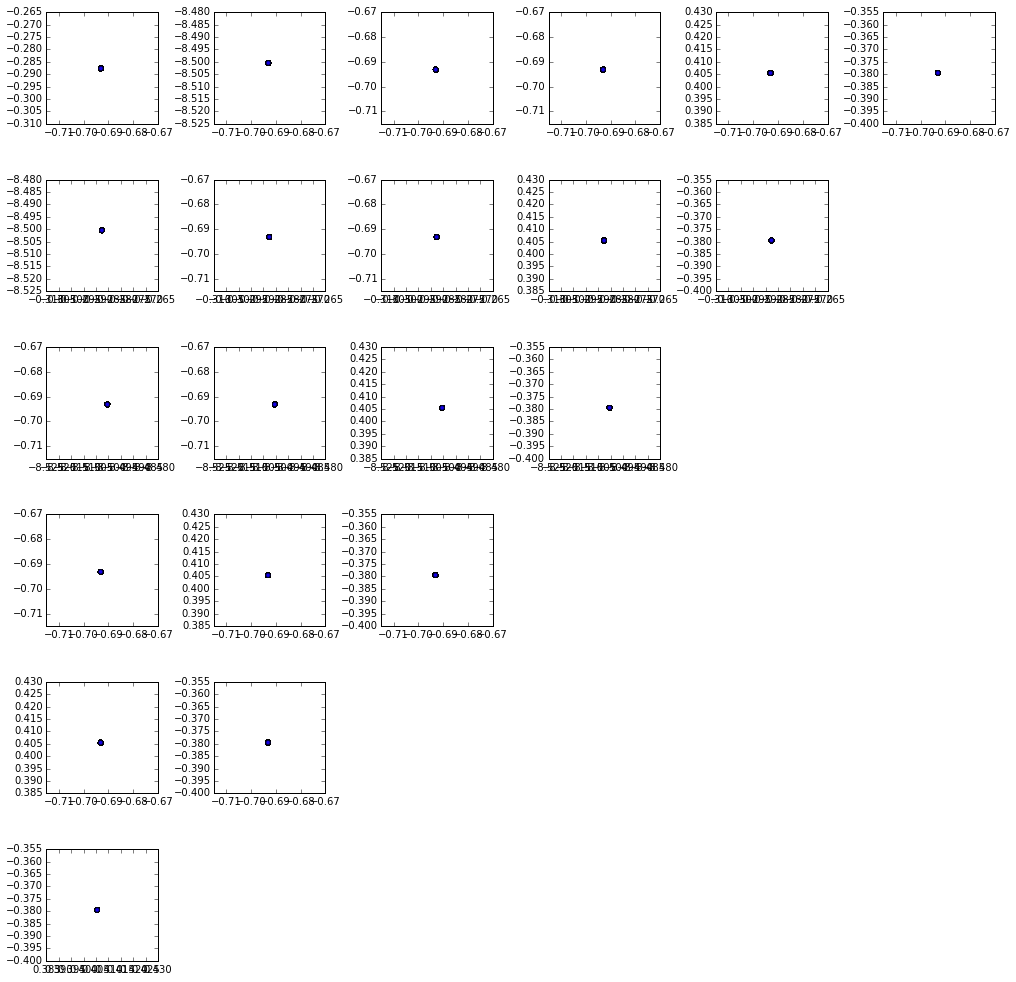

In [23]:
plot_combinatory_two_dim_data(x[:,11:], train_labels)

The two dimensional combinatory plots of the 7 new network features show that there is little variation between the added features. This suggests that the graph features add little predictive value to the model. Since these features come at a significant computational and model complexity cost, we chose not to pursue them in our final model.

## Reference Features

Since our graph centrality measures did not turn out to be useful, perhaps a simpler feature might work better. Next, we used a similar hashing approach to count how many times a user appears across all the provided data.  Our theory is that if a user appears more frequently, it may imply that they're a more prolific user of the social network and, therefore, might typically be considered more influential than their peers who appear less frequently.

In [7]:
def feature_hash(features):
    """Return a hash for the feature array.
    
    @param features: The feature array.
    @return a hash.
    """
    return hashlib.sha1(features).hexdigest()

def generate_reference_dict(data):
    """Generate reference count for A and B in the data set.
    
    Reference count refer to the total occurence for a person among all
    the observations. Noted that, for each A in an observation, the same person can
    occur in B in another observation. Similarly, B in an observation can occur in A
    in another one.
    
    Return a dictionary for which the key and the feature hash and value is the
    reference count.
    
    @param data: The original non-transformed data.
    @return A dictionary containing the reference count for a person.
    """
    reference_count = {}
    for d in data:
        key_A = feature_hash(d[0:11])
        key_B = feature_hash(d[11:])
        if key_A not in reference_count:
            reference_count[key_A] = 1
        else:
            reference_count[key_A] += 1
        if key_B not in reference_count:
            reference_count[key_B] = 1
        else:
            reference_count[key_B] += 1
    return reference_count

# combine train and test data to calculate the total reference count for a person.
reference_dict = generate_reference_dict(np.vstack((X, test_data)))

Number of total people 1744
Number of total people referenced more than once 707


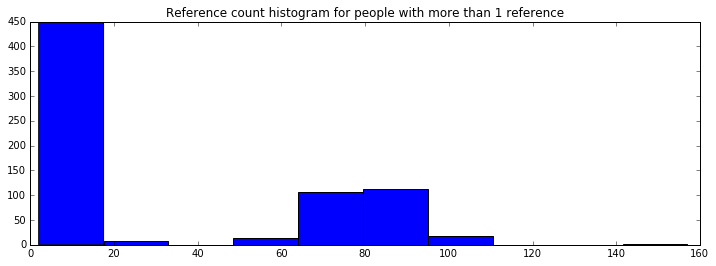

In [15]:
print "Number of total people", len(reference_dict)
print "Number of total people referenced more than once", len(filter(lambda v: v>1, reference_dict.values()))
plt.figure(figsize=(12,4))
plt.subplot(1,1,1)
plt.hist(filter(lambda v: v>1, reference_dict.values()))
plt.title("Reference count histogram for people with more than 1 reference")

There are only 1744 unique people out of the total 11452 observations across both the provided training and test datasets. Out of the 1744, 707 of them appear more than once. Therefore, we assume that the more often a person is referred, the more likely he/she is determined to be more impactful. The following generates the reference count feature for all the people.

In [8]:
def generate_reference_features(data, reference_dict):
    """Generate reference features for A and B in the data set based on the reference count
    dictionary.
    
    A new feature matrix with dimension (n_samples, 2) is returned with
    first dimension being the reference count for A and second being
    the reference count for B.
    
    @param data: The original non-transformed data.
    @return The new feature matrix.
    """
    reference_features = np.ones((data.shape[0], 2))
    
    for i, d in enumerate(data):
        key_A = feature_hash(d[0:11])
        key_B = feature_hash(d[11:])
        reference_features[i,0] = reference_dict[key_A]
        reference_features[i,1] = reference_dict[key_B]
    return reference_features

In [9]:
# Generate reference features for train data set
X_reference_features = generate_reference_features(X, reference_dict)
# Compute the difference between A and B's reference count
ref_feature_transformed = X_reference_features[:,0] - X_reference_features[:,1]
X_transformed_with_ref = np.hstack((X_transformed, ref_feature_transformed[:,np.newaxis]))

# Run through the same prepare_train_data process to split data into train and dev set
ref_train_data, _, ref_dev_data, _ = prepare_train_data(ref_feature_transformed, ref_feature_transformed)
train_data_transformed_with_ref = np.hstack((train_data_transformed, ref_train_data[:,np.newaxis]))
dev_data_transformed_with_ref = np.hstack((dev_data_transformed, ref_dev_data[:,np.newaxis]))

# Generate reference features for test data set
test_ref_feature = generate_reference_features(test_data, reference_dict)
test_ref_feature_transformed = test_ref_feature[:,0] - test_ref_feature[:,1]
test_data_transformed_with_ref = np.hstack((test_data_transformed, test_ref_feature_transformed[:,np.newaxis]))

print np.shape(train_data_transformed_with_ref), np.shape(dev_data_transformed_with_ref), np.shape(test_data_transformed_with_ref)

(4583, 12) (917, 12) (5952, 12)


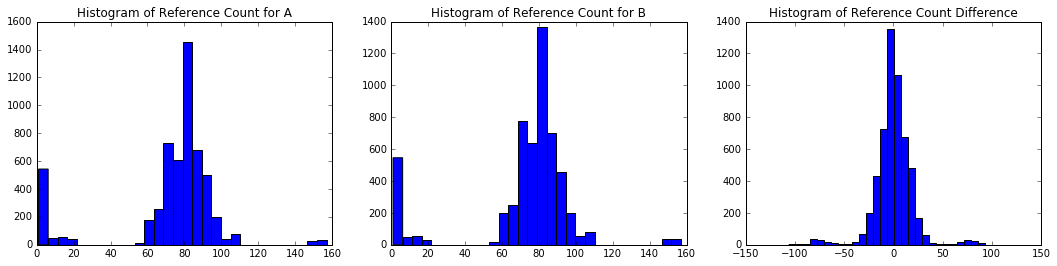

In [10]:
# Examine the new reference count features

plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.hist(X_reference_features[:,0], bins=30)
plt.title("Histogram of Reference Count for A")
plt.subplot(1,3,2)
plt.hist(X_reference_features[:,1], bins=30)
plt.title("Histogram of Reference Count for B")
plt.subplot(1,3,3)
plt.hist(ref_feature_transformed, bins=30)
plt.title("Histogram of Reference Count Difference")

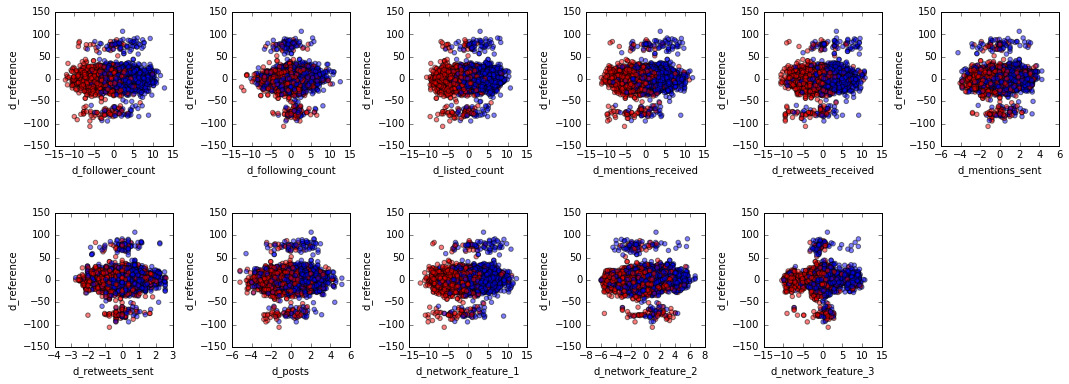

In [11]:
# Scatterplots of the new feature vs all other features

plt.figure(figsize=(18,6))
features_counts = train_data_transformed_with_ref.shape[1]
# Last feature is the new reference feature
for i in range(features_counts-1):
    plt.subplot(2, (features_counts-1)/2 + 1, i+1)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plot_two_dim_data(train_data_transformed_with_ref, train_labels, i, features_counts-1)
    plt.xlabel(features_transformed[i])
    plt.ylabel("d_reference")

The new reference feature clearly introduced two clusters around the central main cluster. Analyzing the cluster above the main one where A has more references than B, there is notably more observations in favor of A (blue). Similar pattern can also be observed for B for the cluster below the main one. Although the main cluster in the center exibits similar pattern as seen before, we would expect the new feature to improve the AUC of the model.

In [12]:
# Use same logistic regression configuration as above and compare result
accuracy_features(train_data_transformed_with_ref, train_labels, dev_data_transformed_with_ref, dev_labels)

AUC: 0.75034


The new feature improves the AUC from 0.748 to 0.75. Due to the hardly separable nature of the data set, this slight improvement still moves our ranking in Kaggle up a couple positions.

# Final Feature Engineering
Using the reference features dataset, we tried different methods to improve predictive power. Much of the discussion on this particular problem on Kaggle mentioned the creation of a balanced feature set in which each feature is offset by a negative counterpart. We also added an additional feature based on the ratio of how many other people a particular user was following versus how many followers that user had.

In [21]:
# For every feature, make a negative copy of it, so that there's a balance between all the cases were 
# A < B and B > A.
def balance_features(data, labels):
    xx = []
    yy = []
    for i in range(len(labels)):
        xx.append(data[i])
        yy.append(labels[i])
        xx.append(-data[i])
        yy.append(1 - labels[i])
    return xx, yy

def balance_features_test(data):
    xx = []
    for i in range(len(data)):
        xx.append(data[i])
    return xx

# For every row, append the ratio following / followers as a new feature
def ratio_features(data):    
    for i in range(len(data)):
        data[i] = np.append(data[i], data[i][0] / (data[i][1] + 1)) 
    return data

In [22]:
# For every feature, make a negative copy of it, so that there's a balance between all the cases were 
# A < B and B > A.
xx, yy = balance_features(train_data_transformed_with_ref, train_labels)
dev_xx, dev_yy = balance_features(dev_data_transformed_with_ref, dev_labels)
test_xx = balance_features_test(test_data_transformed_with_ref)

# For every row, append the ratio following / followers as a new feature
xx = ratio_features(xx)
dev_xx = ratio_features(dev_xx)
tx = ratio_features(test_xx)

print np.shape(xx), np.shape(dev_xx), np.shape(tx)

(9166, 13) (1834, 13) (5952, 13)


In [23]:
accuracy_features(xx, yy, dev_xx, dev_yy)

AUC: 0.75027


Balancing and comparing the ratio of following to followers in the Reference Features did not improve the AUC significantly (0.75034 to 0.75027, a neglible change). We again see difficulty due to the hardly separable nature of the data set.

# Error Analysis and Advanced Modeling

Having tested several different options around newly created features and consistently finding that a large group of difficult-to-separate cases remained, we next looked at ways of addressing this non-linear separation.  First, we tried combining the results of a PCA and Logistic Regression together on our new larger feature space

## PCA and Logistic Regression

In [21]:
pca_lr_pipeline = Pipeline([('pca', PCA()), ('lr', LogisticRegression())])
print "PCA + Logistic Regression Model Calibration:\n"
params = {'pca__n_components': [8, 9, 10, 11],
          'lr__C': [0.001, 0.01, 0.1, 0.5, 1.0]}
lg_grid_cls = train_gridsearch_classifier(pca_lr_pipeline,
                                       params,
                                       xx, yy)
report_score(lg_grid_cls, dev_xx, dev_yy, True)
print "------------------------------------------\n"

PCA + Logistic Regression Model Calibration:

Best param: {'pca__n_components': 10, 'lr__C': 0.01}, AUC: 0.755
------------------------------------------



In [13]:
def train_PCA_LR(train_data, train_labels):
    pca_lr = Pipeline([('pca', PCA(n_components=10)), ('lr', LogisticRegression(C=0.01))])
    pca_lr.fit(train_data, train_labels)
    return pca_lr

In [24]:
pca_lr_model = train_PCA_LR(xx, yy)
preds_lr = pca_lr_model.predict(dev_xx)
roc_auc_score(dev_yy, preds_lr)

0.7546346782988006

Performing PCA transformation before applying logistic regression produces an AUC of 0.7546.

## Random Forest
While we didn't have much success with Random Forest during our intial exploration, we felt it made sense to try again on the new feature space and to apply some additional hyperparameter optimization via our GridSearch implemenation because of its ability to handle nonlinear separation.

In [25]:
print "Random Forest Model Calibration:\n"
params = {'n_estimators': [1, 10, 20, 50, 100, 200, 500]}
rf_grid_cls = train_gridsearch_classifier(RandomForestClassifier(),
                                       params,
                                       xx, yy)
report_score(rf_grid_cls, dev_xx, dev_yy)
print "------------------------------------------\n"

Random Forest Model Calibration:

Parameters scores:
mean: 0.70053, std: 0.00592, params: {'n_estimators': 1}
mean: 0.83573, std: 0.00721, params: {'n_estimators': 10}
mean: 0.84632, std: 0.00686, params: {'n_estimators': 20}
mean: 0.85410, std: 0.00663, params: {'n_estimators': 50}
mean: 0.85668, std: 0.00771, params: {'n_estimators': 100}
mean: 0.85749, std: 0.00771, params: {'n_estimators': 200}
mean: 0.85855, std: 0.00874, params: {'n_estimators': 500}


Best param: {'n_estimators': 500}, AUC: 0.748
------------------------------------------



In [14]:
def train_RF(train_data, train_labels):
    rf = RandomForestClassifier(n_estimators=200)
    rf.fit(train_data, train_labels)
    return rf

In [28]:
rf_model = train_RF(xx, yy)
preds_rf = rf_model.predict(dev_xx)
roc_auc_score(dev_yy, preds_rf)

0.7453653217011994

Using cross validation, Random Forest with 100 to 500 estimators gives the best performance. Due to the random nature of the algorithm, the best number of estimators can be any number between the range. To avoid underfitting the model using too many parameters because of the relatively small data set, we pick 200 as the calibrated parameter which also gives better performance empirically using the test data set. Using this configuration, the Random Forest model generally performs worse than the PCA+LogisticRegression model.

## Bagging with Logistic Regression <a id='bagging_with_LR'></a>
After seeing the success of Random Forest, we wondered how the use of a bagging approach alongside logistic regression might compare.

In [29]:
print "Bagging with Logistic Regression Calibration:\n"
params = {
    'base_estimator': [LogisticRegression(C=1)],
    'n_estimators': [50, 100, 200],
    'max_samples': [0.3, 0.5, 0.8],
    'max_features': [0.3, 0.5, 0.8],
}
rf_grid_cls = train_gridsearch_classifier(BaggingClassifier(),
                                       params,
                                       xx, yy)
report_score(rf_grid_cls, dev_xx, dev_yy, True)
print "------------------------------------------\n"

Bagging with Logistic Regression Calibration:

Best param: {'max_features': 0.8, 'max_samples': 0.5, 'base_estimator': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'n_estimators': 50}, AUC: 0.746
------------------------------------------



In [15]:
def train_LR_bagging(train_data, train_labels):
    bag_lr = BaggingClassifier(base_estimator=LogisticRegression(C=1), n_estimators=50, max_features=0.5, max_samples=0.8)
    bag_lr.fit(train_data, train_labels)
    return bag_lr

In [31]:
bag_lr_model = train_LR_bagging(xx,yy)
preds_bag_lr = bag_lr_model.predict(dev_xx)
roc_auc_score(dev_yy, preds_bag_lr)

0.742639040348964

As an ensemble method, bagging generally performs worse compared to random forest. This suggests that using a decision tree on the raw features is more effective than applying regression. Intuitively, this makes sense because of the hardly linearly separable data set which is better suited to Random Forest's ability to handle non-linear boundaries.

## PCA + Logistic Regression + Random Forest

Knowing that we've seen partial success with both Logistic Regression and Random Forest, we tried combining the two together in hopes that logistic regression would continue to successfully classify the points further from the boundary, while random forest would be better suited to address the remaining non-linearity in the central cluster.  To combine these two models, we use the VotingClassifer class, which enables the assignment of a weight to each component model.  We can then optimize these weights again using our GridSearch implementation.

In [32]:
print "Calibration for Logistic Regression + Random Forest Ensemble Model:\n"
pca_lr = Pipeline([('pca', PCA(n_components=10)), ('lr', LogisticRegression(C=0.01))])
rf = RandomForestClassifier(n_estimators=200)
lr_rf = VotingClassifier(estimators=[('pca_lr', pca_lr), ('rf', rf)], voting='soft')
params = {'weights': [[0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]}

voting_grid_cls = train_gridsearch_classifier(lr_rf,
                                       params,
                                       xx, yy)
report_score(voting_grid_cls, dev_xx, dev_yy)
print "------------------------------------------\n"

Calibration for Logistic Regression + Random Forest Ensemble Model:

Parameters scores:
mean: 0.85995, std: 0.00750, params: {'weights': [0.1, 0.9]}
mean: 0.86316, std: 0.00715, params: {'weights': [0.3, 0.7]}
mean: 0.86485, std: 0.00765, params: {'weights': [0.5, 0.5]}
mean: 0.86536, std: 0.00689, params: {'weights': [0.7, 0.3]}
mean: 0.86398, std: 0.00614, params: {'weights': [0.9, 0.1]}


Best param: {'weights': [0.7, 0.3]}, AUC: 0.755
------------------------------------------



In [24]:
def train_LR_RF(train_data, train_labels):
    pca_lr = Pipeline([('pca', PCA(n_components=10)), ('lr', LogisticRegression(C=0.01))])
    rf = RandomForestClassifier(n_estimators=200)
    lr_rf = VotingClassifier(estimators=[('pca_lr', pca_lr), ('rf', rf)], voting='soft', weights=[0.7, 0.3])
    lr_rf.fit(train_data, train_labels)
    return lr_rf

In [25]:
lr_rf_model = train_LR_RF(xx, yy)
preds_lr_rf = lr_rf_model.predict(dev_xx)
roc_auc_score(dev_yy, preds_lr_rf)

0.75463467829880049

In general, using Random Forest along with Logistic Regression improves the results. To avoid overfitting, LR should have larger weight for which the calibrated ensemble model has 0.7 and 0.3 for LR and RF respectively. [ROC curve](#roc_curve) also shows that Random Forest performs worse than PCA + Logistic Regression. However, the combination of them slightly improves the AUC.

## ROC Curves
Having created a set of optmized models that all perform relatively similarly, we felt it would be helpful to plot the ROC curves themselves to get a more precise understanding of the differences between the models beyond the single AUC summary statistic to double-check that we hadn't missed any additional optimization opportunities.

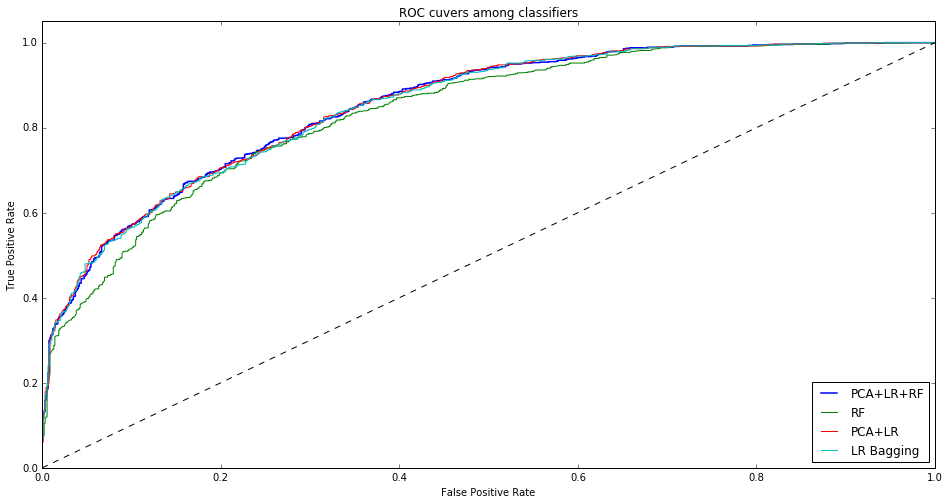

In [58]:
pca_lr_fpr, pca_lr_tpr, _ = metrics.roc_curve(dev_yy, pca_lr_model.predict_proba(dev_xx)[:,1])
rf_fpr, rf_tpr, _ = metrics.roc_curve(dev_yy, rf_model.predict_proba(dev_xx)[:,1])
bag_lr_fpr, bag_lr_tpr, _ = metrics.roc_curve(dev_yy, bag_lr_model.predict_proba(dev_xx)[:,1])
lr_rf_fpr, lr_rf_tpr, _ = metrics.roc_curve(dev_yy, lr_rf_model.predict_proba(dev_xx)[:,1])

plt.figure(figsize=(16,8))
plt.plot(lr_rf_fpr, lr_rf_tpr, label="PCA+LR+RF", linewidth=1.5)
plt.plot(rf_fpr, rf_tpr, label="RF")
plt.plot(pca_lr_fpr, pca_lr_tpr, label="PCA+LR")
plt.plot(bag_lr_fpr, bag_lr_tpr, label="LR Bagging")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC cuvers among classifiers')
plt.legend(loc="lower right")
plt.show()

The ROC curves confirm with the previous investigation that the data is intrinsically hard to improve the results due to the linearly non-separable space around the centroid. Using feature engineering and ensemble modelling techniques only improve performance marginally. However, on the positive end, the ROC curves show that we can achieve 80% true positive rate by allowing about 30% false positive prediction. Therefore, the features in the data set provides fairly accurate signals in predicting the influence of a person.

# Kaggle Submission
In summary the best solution we submitted to Kaggle consists of the following:
- **Feature Transforms**: Log of pairwise differences
- **New Features:** Reference features, following/followers ratios, positive/negative offsets
- **Model 1:** PCA + Logistic Regression (10 PCA components, C=0.01)
- **Model 2:** Random Forest (200 estimators)
- **Final Result:** Combining Model 1 (70%) and Model 2 (30%) via a Voting Classifier

In [80]:
def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(prob[1])+'\n')

In [81]:
submission_model = train_LR_RF(xx+dev_xx, yy+dev_yy)
pred_probs = submission_model.predict_proba(tx)

generate_test_output(pred_probs)

Using the Logistic Regression + Random Forest model, we achieve a Kaggle AUC of 0.86403 which places us in 58th position out of 132 participants, given that the top score is 0.88162.

# Appendix
In addition to the main ideas described above, we also explored several paths that turned out to be dead ends.  We've included these components below for completeness, though they did not directly inform our final Kaggle submission.
* [Additional Raw Data Visualizations](#Additional-Raw-Data-Visualizations)
* [Measuring Feature Importance Using Random Forests](#Measuring-Feature-Importance-Using-Random-Forests)
* [Kernel PCA Features Visualization](#Kernel-PCA-Features-Visualization)
* [Neural Network Implementation Using TensorFlow](#Neural-Network-Implementation-Using-TensorFlow)

# Additional Raw Data Visualizations

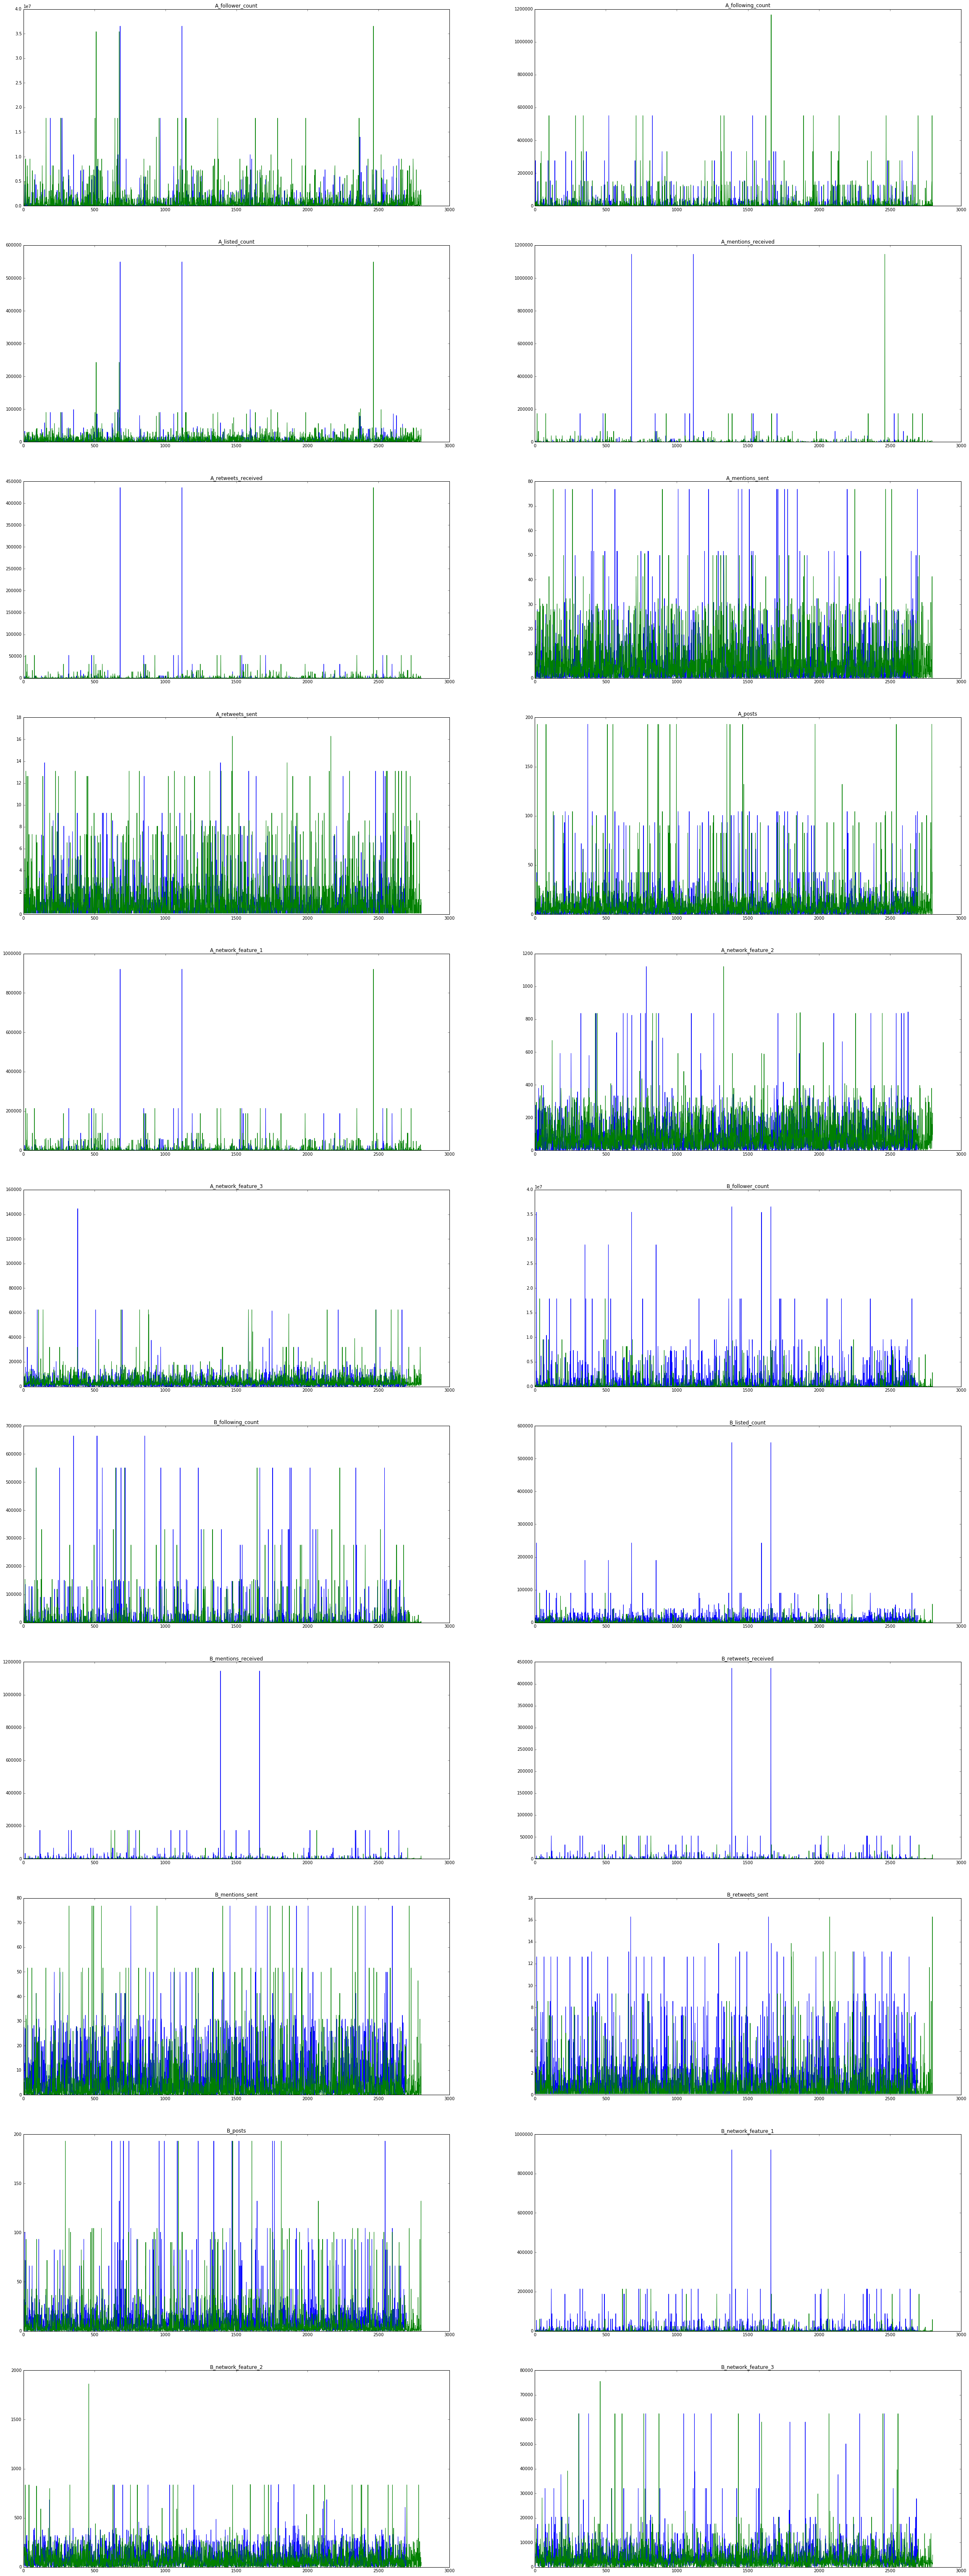

In [208]:
# creating plots of our raw data for the training data with label = 0
train_data_0 = X[Y==0]
train_data_1 = X[Y==1]

fig = plt.figure(figsize=(40,220))

ax1=fig.add_subplot(22,2,1)
ax2=fig.add_subplot(22,2,2)
ax3=fig.add_subplot(22,2,3)
ax4=fig.add_subplot(22,2,4)
ax5=fig.add_subplot(22,2,5)
ax6=fig.add_subplot(22,2,6)
ax7=fig.add_subplot(22,2,7)
ax8=fig.add_subplot(22,2,8)
ax9=fig.add_subplot(22,2,9)
ax10=fig.add_subplot(22,2,10)
ax11=fig.add_subplot(22,2,11)
ax12=fig.add_subplot(22,2,12)
ax13=fig.add_subplot(22,2,13)
ax14=fig.add_subplot(22,2,14)
ax15=fig.add_subplot(22,2,15)
ax16=fig.add_subplot(22,2,16)
ax17=fig.add_subplot(22,2,17)
ax18=fig.add_subplot(22,2,18)
ax19=fig.add_subplot(22,2,19)
ax20=fig.add_subplot(22,2,20)
ax21=fig.add_subplot(22,2,21)
ax22=fig.add_subplot(22,2,22)

ax1.plot(train_data_0[:,0])
ax1.plot(train_data_1[:,0])
ax1.set_title('A_follower_count')

ax2.plot(train_data_0[:,1])
ax2.plot(train_data_1[:,1])
ax2.set_title('A_following_count')

ax3.plot(train_data_0[:,2])
ax3.plot(train_data_1[:,2])
ax3.set_title('A_listed_count')

ax4.plot(train_data_0[:,3])
ax4.plot(train_data_1[:,3])
ax4.set_title('A_mentions_received')

ax5.plot(train_data_0[:,4])
ax5.plot(train_data_1[:,4])
ax5.set_title('A_retweets_received')

ax6.plot(train_data_0[:,5])
ax6.plot(train_data_1[:,5])
ax6.set_title('A_mentions_sent')

ax7.plot(train_data_0[:,6])
ax7.plot(train_data_1[:,6])
ax7.set_title('A_retweets_sent')

ax8.plot(train_data_0[:,7])
ax8.plot(train_data_1[:,7])
ax8.set_title('A_posts')

ax9.plot(train_data_0[:,8])
ax9.plot(train_data_1[:,8])
ax9.set_title('A_network_feature_1')

ax10.plot(train_data_0[:,9])
ax10.plot(train_data_1[:,9])
ax10.set_title('A_network_feature_2')

ax11.plot(train_data_0[:,10])
ax11.plot(train_data_1[:,10])
ax11.set_title('A_network_feature_3')

ax12.plot(train_data_0[:,11])
ax12.plot(train_data_1[:,11])
ax12.set_title('B_follower_count')

ax13.plot(train_data_0[:,12])
ax13.plot(train_data_1[:,12])
ax13.set_title('B_following_count')

ax14.plot(train_data_0[:,13])
ax14.plot(train_data_1[:,13])
ax14.set_title('B_listed_count')

ax15.plot(train_data_0[:,14])
ax15.plot(train_data_1[:,14])
ax15.set_title('B_mentions_received')

ax16.plot(train_data_0[:,15])
ax16.plot(train_data_1[:,15])
ax16.set_title('B_retweets_received')

ax17.plot(train_data_0[:,16])
ax17.plot(train_data_1[:,16])
ax17.set_title('B_mentions_sent')

ax18.plot(train_data_0[:,17])
ax18.plot(train_data_1[:,17])
ax18.set_title('B_retweets_sent')

ax19.plot(train_data_0[:,18])
ax19.plot(train_data_1[:,18])
ax19.set_title('B_posts')

ax20.plot(train_data_0[:,19])
ax20.plot(train_data_1[:,19])
ax20.set_title('B_network_feature_1')

ax21.plot(train_data_0[:,20])
ax21.plot(train_data_1[:,20])
ax21.set_title('B_network_feature_2')

ax22.plot(train_data_0[:,21])
ax22.plot(train_data_1[:,21])
ax22.set_title('B_network_feature_3')

#Measuring Feature Importance Using Random Forests

 1) A_follower_count               0.076337
 2) A_following_count              0.074925
 3) A_listed_count                 0.073932
 4) A_mentions_received            0.070351
 5) A_retweets_received            0.066699
 6) A_mentions_sent                0.066388
 7) A_retweets_sent                0.063801
 8) A_posts                        0.059060
 9) A_network_feature_1            0.049752
10) A_network_feature_2            0.045217
11) A_network_feature_3            0.033433
12) B_follower_count               0.032178
13) B_following_count              0.032043
14) B_listed_count                 0.031661
15) B_mentions_received            0.031631
16) B_retweets_received            0.031505
17) B_mentions_sent                0.031205
18) B_retweets_sent                0.030923
19) B_posts                        0.029866
20) B_network_feature_1            0.029812
21) B_network_feature_2            0.020230
22) B_network_feature_3            0.019052


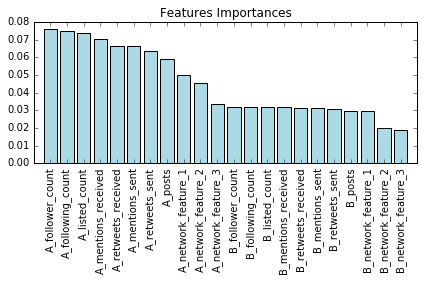

In [36]:
##Usuing a random forest to measure the feature importance

from sklearn.ensemble import RandomForestClassifier

feat_labels = ['A_follower_count', 'A_following_count', 'A_listed_count', 'A_mentions_received', 
               'A_retweets_received', 'A_mentions_sent', 'A_retweets_sent', 'A_posts', 'A_network_feature_1',
               'A_network_feature_2','A_network_feature_3','B_follower_count','B_following_count',
               'B_listed_count','B_mentions_received','B_retweets_received','B_mentions_sent',
               'B_retweets_sent','B_posts','B_network_feature_1','B_network_feature_2','B_network_feature_3']

forest = RandomForestClassifier(n_estimators = 1000, random_state = 0, n_jobs = -1)
forest.fit(X,Y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[f], importances[indices[f]]))
    
plt.title('Features Importances')
plt.bar(range(X.shape[1]),importances[indices], color='lightblue', align='center')
plt.xticks(range(X.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

## KernelPCA Visualization

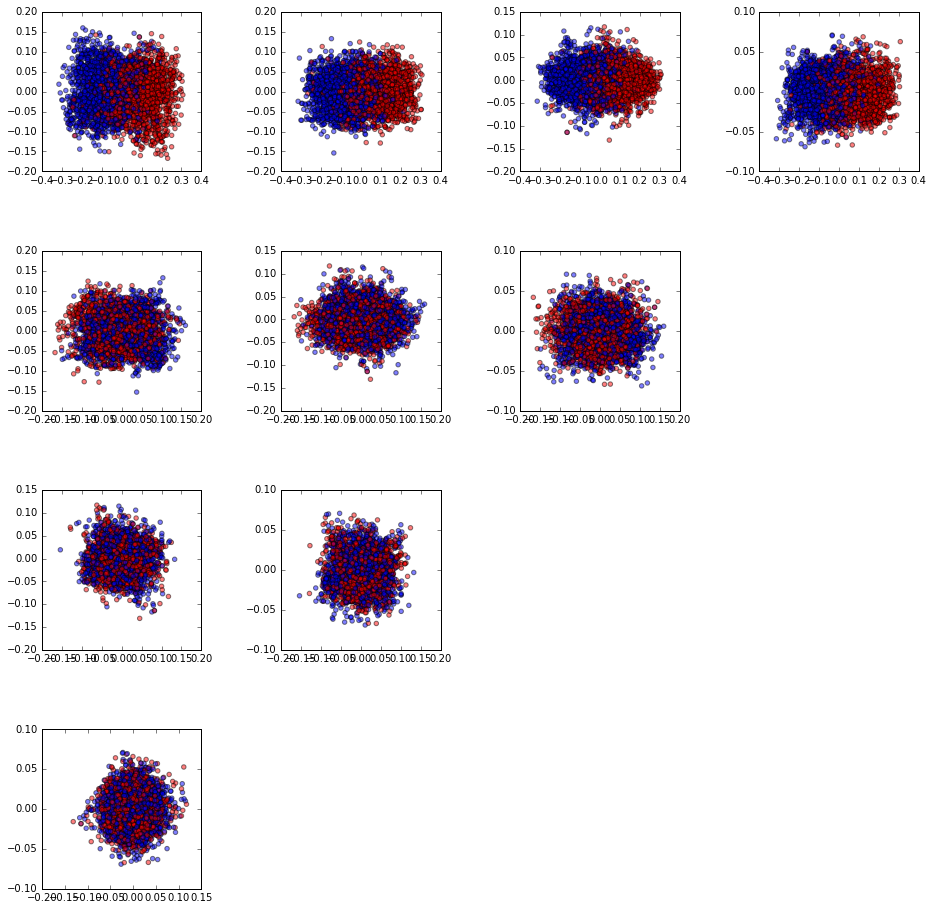

In [24]:
kernel_pca = KernelPCA(n_components=5, gamma=0.0001, kernel='rbf')
train_data_kernel_transform = kernel_pca.fit_transform(train_data_transformed)
plot_combinatory_two_dim_data(train_data_kernel_transform, train_labels)

# Neural Network Implementation Using TensorFlow

In [86]:
tf_session = tf.InteractiveSession()

class NeuralNetworkClassifier(BaseEstimator):
    def __init__(self, epochs=100, batch_size=20, hidden_nodes=5, keep_prob=0.5, relu=True, learning_rate=0.0001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.hidden_nodes = hidden_nodes
        self.keep_prob = keep_prob
        self.relu = relu
        self.learning_rate = learning_rate
        
        # tensor specification
        self._tf_X_model = None
        self._tf_Y_model = None
        self._tf_keep_prob = None
        self._tf_y_hat = None
        self._tf_train = None

    def fit(self, X, y):
        binarized_y = self._binarize_labels(y)
        
        # Input/Output specification
        self._tf_X_model = tf.placeholder("float", shape=[None, X.shape[1]])
        self._tf_Y_model = tf.placeholder("float", shape=[None, binarized_y.shape[1]])
        
        # Parameters specification
        W_1 = self._weight_variable([X.shape[1], self.hidden_nodes])
        b_1 = self._bias_variable([self.hidden_nodes])

        W_2 = self._weight_variable([self.hidden_nodes, binarized_y.shape[1]])
        b_2 = self._bias_variable([binarized_y.shape[1]])
        
        # Model
        activate_f = self._activation_function()
        h_1 = activate_f(tf.matmul(self._tf_X_model, W_1) + b_1)
        # Use dropout probability to avoid overfitting
        self._tf_keep_prob = tf.placeholder("float")
        h_1_drop = tf.nn.dropout(h_1, self._tf_keep_prob)
        self._tf_y_hat = tf.nn.softmax(tf.matmul(h_1_drop, W_2) + b_2)
        
        # Cost
        cross_entropy = -tf.reduce_sum(self._tf_Y_model*tf.log(self._tf_y_hat))
        self._tf_train = tf.train.AdamOptimizer(self.learning_rate).minimize(cross_entropy)
        self._stochastic_train(X, binarized_y)

        return self
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def predict_proba(self, X):
        return self._tf_y_hat.eval(feed_dict={self._tf_X_model: X, self._tf_keep_prob: 1.0})
    
    def _binarize_labels(self, labels):
        binarized_labels = np.zeros([labels.shape[0], int(np.max(labels) + 1)])
        for i, label in enumerate(labels):
            binarized_labels[i, int(label)] = 1.0
        return binarized_labels
    
    def _weight_variable(self, shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

    def _bias_variable(self, shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)
    
    def _activation_function(self):
        if self.relu:
            # rectified linear: max(features, 0)
            return tf.nn.relu
        else:
            return tf.nn.softmax

    def _stochastic_train(self, X, y):
        tf_session.run(tf.initialize_all_variables())
        for i in range(self.epochs):       
            for start, end in zip(
                range(0, len(X), self.batch_size),
                range(self.batch_size, len(X), self.batch_size)
            ):
                self._tf_train.run(feed_dict={
                        self._tf_X_model: X[start:end],
                        self._tf_Y_model: y[start:end],
                        self._tf_keep_prob: self.keep_prob
                    })


In [74]:
nn = NeuralNetworkClassifier(epochs=100, batch_size=20, hidden_nodes=6, keep_prob=1.0, learning_rate=0.0001)
nn.fit(np.array(xx), np.array(yy))
pred_proba = nn.predict_proba(np.array(dev_xx))
roc_auc_score(np.array(dev_yy), pred_proba[:,1])

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x1172d01d0>> ignored


0.85309357120856633

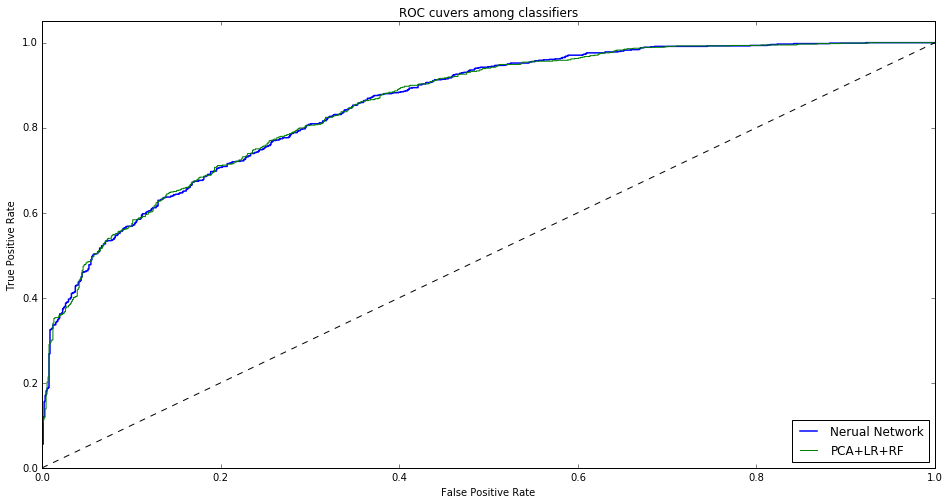

In [75]:
nn_fpr, nn_tpr, _ = metrics.roc_curve(np.array(dev_yy), pred_proba[:,1])
lr_rf_fpr, lr_rf_tpr, _ = metrics.roc_curve(dev_yy, lr_rf_model.predict_proba(dev_xx)[:,1])

plt.figure(figsize=(16,8))
plt.plot(nn_fpr, nn_tpr, label="Nerual Network", linewidth=1.5)
plt.plot(lr_rf_fpr, lr_rf_tpr, label="PCA+LR+RF")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC cuvers among classifiers')
plt.legend(loc="lower right")
plt.show()

Surprisingly, neural network gives a notably higher AUC score compared to all other methods we used before. However, it does not show any outstanding performance compared to PCA+LR+RF in the ROC curve. In addition, using the neural network along and some ensemble methods also does not improve the performance on test set in Kaggle. It seems that even with the extra hidden layer, the non-linear data space is still fairly hard to separate.